In [1]:
from pathlib import Path
import torch
from torch import nn,optim
from mltools import ld,draw,models

In [2]:
vocab,train_iter,val_iter,test_iter=ld.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv') # 加载词表，数据集
rnn_layer=nn.LSTM(len(vocab), hidden_size=512, batch_first=True, bidirectional=True) # 定义循环网络LSTM
model=models.RNNModel(rnn_layer, vocab_size=len(vocab), step_size=200, output_size=2) # 定义训练模型
device=torch.device('cuda')
model_path='../model/LSTM_CSC.pth'

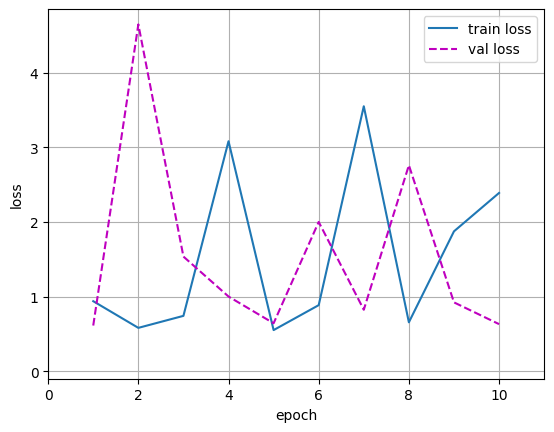

In [3]:
# 训练
def train(model, train_iter, val_iter, vocab, *, num_epochs, learning_rate, device):
    model.to(device) # 将网络复制到device上
    loss = nn.CrossEntropyLoss() # 定义损失函数
    optimizer = torch.optim.SGD(model.parameters(), learning_rate) # 定义优化器
    animator=draw.Animator(line_num=2,xlabel='epoch',ylabel='loss',xlim=[0, num_epochs+1],ylim=-0.1,legend=['train loss','val loss'])
    for epoch in range(num_epochs):
        # 计算训练集
        for x, y in train_iter:
            # 运算
            x, y = x.to(device), y.to(device)
            y_train, _ = model(x)
            train_loss = loss(y_train, y)
            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
            optimizer.step()
        # 计算验证集
        with torch.no_grad():
            for x, y in val_iter:
                # 运算
                x, y = x.to(device), y.to(device)
                y_val, _ = model(x)
                val_loss = loss(y_val, y)
        animator.add(train_loss.detach().cpu(),val_loss.detach().cpu()) # 添加损失值

if Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    train(model,train_iter,val_iter,vocab,num_epochs=10,learning_rate=1e-1,device=device)
    torch.save(model.state_dict(), model_path)

In [4]:
# 测试模型
def test(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    test_num,real_num=0,0 # 定义测试数量和预测真实数量
    # 测试
    for x,y in test_iter:
        x,y=x.to(device),y.to(device)
        y_test, _ = model(x)
        y_test=y_test.argmax(dim=1)
        pred=y==y_test
        test_num+=len(pred)
        real_num+=pred.sum()
    print(f'Accuracy rate {real_num/test_num}') # 计算测试准确率并输出
test(model,test_iter,device)

Accuracy rate 0.6020583510398865


In [5]:
# 预测模型
def predict(model, test_iter, device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x, y = next(iter(test_iter))
    x, y = x[:10].to(device), y[:10].to(device)
    values = [''.join(item) for item in vocab[x.tolist()]]
    # 预测
    y_pred, _ = model(x)
    y_pred = y_pred.argmax(dim=1)
    for pred, true, value in zip(y_pred, y, values):
        print(f'预测值 {pred}, 真实值 {true}, 数据 {value}')
predict(model, test_iter, device)

预测值 0, 真实值 1, 数据 带孩子入住只是希望能畅游迪士尼乐园（住客可以一次购票两天入园且中途可以自由出入），感觉还是值得的：整个园区景观幽雅，植被丰茂，各条园路均引人入胜，建议有时间可以四处走走。酒店环境不错，房间宽敞整洁，床很大，可以算作两张双人床；订的海景房，窗外远眺海湾，看渡轮往返，赏烟雨迷蒙，心旷神怡；晚餐自助餐尚可，早餐不敢恭维，孩子们如果喜欢与米奇合影，也可以尝试；建议下午六点左右回酒店到日落大道走走，海滨、晚
预测值 0, 真实值 1, 数据 对本次入住的酒店,感觉很不错,因为我本人蛮注重环境的,每次入住酒店都会查看点评的,所以选了这间酒店,地方也很好找的,我们入住的是395的房间,但是他们给了我们一个价值888的房间给我们体验,真是太舒服了,早餐是价值88元的,很丰富,真的是超赞的,极力推荐!!!!!!!!!!!1<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
预测值 1, 真实值 1, 数据 还成,不错还成,不错还成,不错还成,不错,物有所值<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa